In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')  # Tắt cảnh báo

# Đọc dữ liệu từ file CSV
file_path = "D:/New folder/default of credit card clients.csv"
df = pd.read_csv(file_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  int64 
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  int64 
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  int64 
 6   PAY_STATUS_Sept             30000 non-null  int64 
 7   PAY_STATUS_Aug              30000 non-null  int64 
 8   PAY_STATUS_Jul              30000 non-null  int64 
 9   PAY_STATUS_Jun              30000 non-null  int64 
 10  PAY_STATUS_May              30000 non-null  int64 
 11  PAY_STATUS_Apr              30000 non-null  int64 
 12  BILL_BALANCE_Sept           30000 non-null  int64 
 13  BILL_BALANCE_Aug            30000 non-null  in

In [2]:
# Kiểm tra giá trị thiếu
print(df.isnull().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_STATUS_Sept               0
PAY_STATUS_Aug                0
PAY_STATUS_Jul                0
PAY_STATUS_Jun                0
PAY_STATUS_May                0
PAY_STATUS_Apr                0
BILL_BALANCE_Sept             0
BILL_BALANCE_Aug              0
BILL_BALANCE_Jul              0
BILL_BALANCE_Jun              0
BILL_BALANCE_May              0
BILL_BALANCE_Apr              0
PAY_AMOUNT_Sept               0
PAY_AMOUNT_Aug                0
PAY_AMOUNT_Jul                0
PAY_AMOUNT_Jun                0
PAY_AMOUNT_May                0
PAY_AMOUNT_Apr                0
default payment next month    0
dtype: int64


In [3]:
# Mã hóa SEX
df["SEX"] = df["SEX"].map({"Nam": 1, "Nữ": 0})

# Mã hóa MARRIAGE
marriage_mapping = {"Đã kết hôn": 1, "Độc thân": 2, "Khác": 3, "0": 3}
df["MARRIAGE"] = df["MARRIAGE"].map(marriage_mapping)

# Gộp nhóm EDUCATION (0, 4, 5, 6 thành "Khác" với giá trị là 4)
df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})

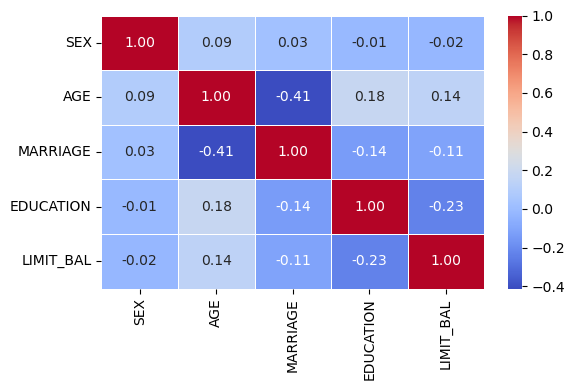

In [4]:
# Ma trận tương quan giữa các biến nhấn khẩu học và HMTD
demo = df[['SEX', 'AGE', 'MARRIAGE', 'EDUCATION', 'LIMIT_BAL']]
correlation_matrix_demo = demo.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix_demo, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.tight_layout()
plt.show()

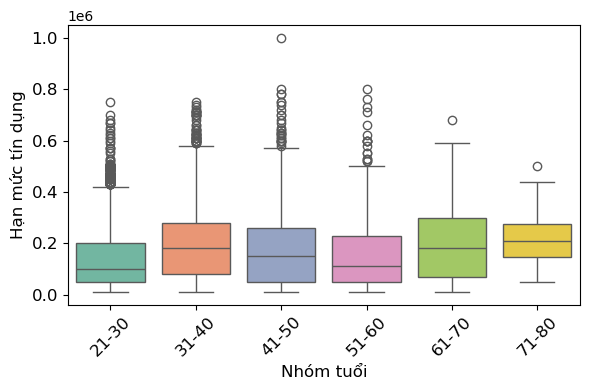

In [5]:
# Vẽ biểu đồ boxplot cho LIMIT_BAL theo nhóm tuổi đã chia
bins = [20, 30, 40, 50, 60, 70, 80]
names = ['21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=names, right=True)
# Vẽ biểu đồ boxplot cho LIMIT_BAL theo nhóm tuổi đã chia
plt.figure(figsize=(6, 4))
sns.boxplot(x='AGE_GROUP', y='LIMIT_BAL', data=df, palette='Set2')
plt.xlabel('Nhóm tuổi', fontsize=12)
plt.ylabel('Hạn mức tín dụng', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

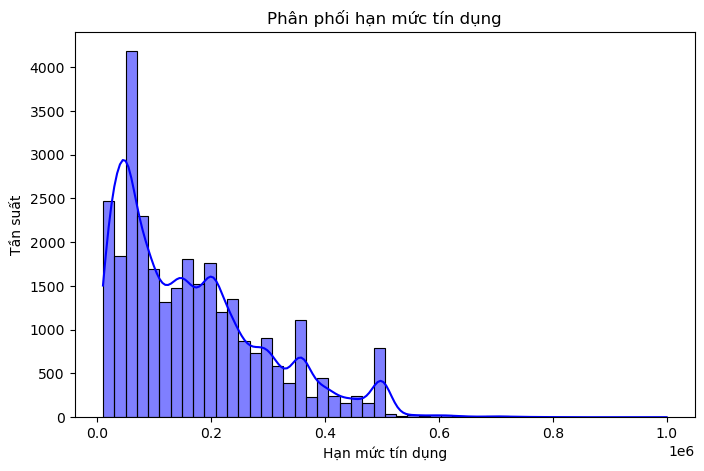

In [6]:
# Phân tích phân phối của hạn mức tín dụng 
plt.figure(figsize=(8, 5))
sns.histplot(df["LIMIT_BAL"], bins=50, kde=True, color="blue")  
plt.title("Phân phối hạn mức tín dụng")
plt.xlabel("Hạn mức tín dụng")
plt.ylabel("Tần suất")
plt.show()

Tạo các đặc trưng mới

In [7]:
# Tỷ lệ sử dụng tín dụng
bill_balance_cols = ["BILL_BALANCE_Apr", "BILL_BALANCE_May", "BILL_BALANCE_Jun", 
                     "BILL_BALANCE_Jul", "BILL_BALANCE_Aug", "BILL_BALANCE_Sept"]
df["CUR"] = df[bill_balance_cols].mean(axis=1) / (df["LIMIT_BAL"] + 1)

# Tỷ lệ thanh toán so với số dư nợ
pay_amount_cols = ["PAY_AMOUNT_Apr", "PAY_AMOUNT_May", "PAY_AMOUNT_Jun", 
                   "PAY_AMOUNT_Jul", "PAY_AMOUNT_Aug", "PAY_AMOUNT_Sept"]
df["repayment_ratio"] = df[pay_amount_cols].sum(axis=1) / (df[bill_balance_cols].sum(axis=1) + 1)

# Số dư hóa đơn
df["pay_amount"] = df[pay_amount_cols].mean(axis=1)

In [8]:
# Trung bình trạng thái thanh toán
pay_status_cols = ["PAY_STATUS_Apr", "PAY_STATUS_May", "PAY_STATUS_Jun", 
                   "PAY_STATUS_Jul", "PAY_STATUS_Aug", "PAY_STATUS_Sept"]
df["avg_pay_status"] = df[pay_status_cols].mean(axis=1)  

# Tổng số tiền thanh toán
df["bill_balance"] = df[bill_balance_cols].sum(axis = 1)

# Ước lượng thu nhập dựa trên hạn mức tín dụng
df["estimated_income"] = df["LIMIT_BAL"] * 1/3

In [10]:
# Xử lý ngoại lai
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Loại bỏ các dòng có giá trị ngoài phạm vi IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Các cột cần xử lý ngoại lai
columns_to_check = ['LIMIT_BAL', 'CUR', 'repayment_ratio', 'estimated_income', 'BILL_BALANCE_Apr', 'BILL_BALANCE_May', 
                    'BILL_BALANCE_Jun', 'BILL_BALANCE_Jul', 'BILL_BALANCE_Aug', 'BILL_BALANCE_Sept', 
                    'PAY_AMOUNT_Apr', 'PAY_AMOUNT_May', 'PAY_AMOUNT_Jun', 'PAY_AMOUNT_Jul', 'PAY_AMOUNT_Aug', 'PAY_AMOUNT_Sept']

# Áp dụng xử lý ngoại lai
df_cleaned = remove_outliers(df, columns_to_check)

# Kiểm tra số dòng sau khi xử lý
print(f"Số dòng sau khi xử lý ngoại lai: {df_cleaned.shape[0]}")


Số dòng sau khi xử lý ngoại lai: 15433


In [11]:
# Xóa cột AGE_GROUP
df = df.drop(columns=['AGE_GROUP'])

XÂY DỰNG MÔ HÌNH DỰ ĐOÁN HẠN MỨC TÍN DỤNGDỤNG

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Tách dữ liệu thành X (đặc trưng) và y (biến mục tiêu LIMIT_BAL)
X = df.drop(columns=["LIMIT_BAL", "default payment next month", "ID"])  # Loại bỏ cột không liên quan
y = df["LIMIT_BAL"]  # Biến mục tiêu là LIMIT_BAL

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Khởi tạo các tham số
rf_model = RandomForestRegressor(
    n_estimators=100, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='log2', 
    max_depth=30, 
    bootstrap=False, 
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test_scaled)

# Đánh giá mô hình
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

# Tính RMSE và MAE theo phần trăm
mean_limit_bal = y_test.mean()  

# Tính phần trăm RMSE và MAE so với giá trị trung bình của LIMIT_BAL
rmse_percent = (rmse / mean_limit_bal) * 100
mae_percent = (mae / mean_limit_bal) * 100

# Hiển thị kết quả dưới dạng phần trăm cho RMSE và MAE
print(f"RMSE: {rmse:.2f} ({rmse_percent:.2f}%)")
print(f"MAE: {mae:.2f} ({mae_percent:.2f}%)")
print(f"R²: {r2:.6f}")


RMSE: 14137.02 (8.42%)
MAE: 7651.65 (4.55%)
R²: 0.987804


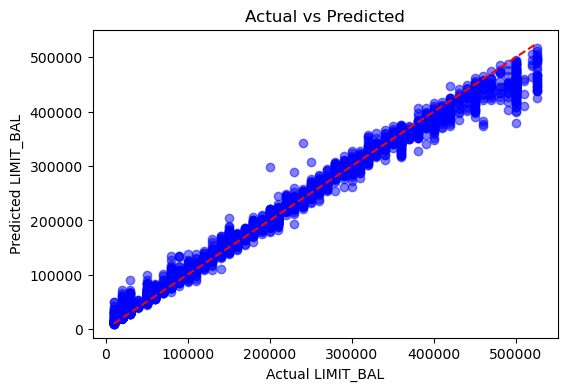

In [14]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual LIMIT_BAL')
plt.ylabel('Predicted LIMIT_BAL')
plt.show()

In [15]:
# Khởi tạo và huấn luyện mô hình
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=50,  # Giảm số lượng cây
    max_depth=5,      # Giảm độ sâu của cây
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# Huấn luyện mô hình
xgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Đánh giá mô hình
rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)
# Tính RMSE và MAE theo phần trăm
mean_limit_bal = y_test.mean()  # Giá trị trung bình của LIMIT_BAL

# Tính phần trăm RMSE và MAE so với giá trị trung bình của LIMIT_BAL
rmse_percent = (rmse / mean_limit_bal) * 100
mae_percent = (mae / mean_limit_bal) * 100
print(f"RMSE: {rmse:.2f} ({rmse_percent:.2f}%)")
print(f"MAE: {mae:.2f} ({mae_percent:.2f}%)")
print(f"R²: {r2:.6f}")

RMSE: 671.67 (0.40%)
MAE: 543.46 (0.32%)
R²: 0.999972


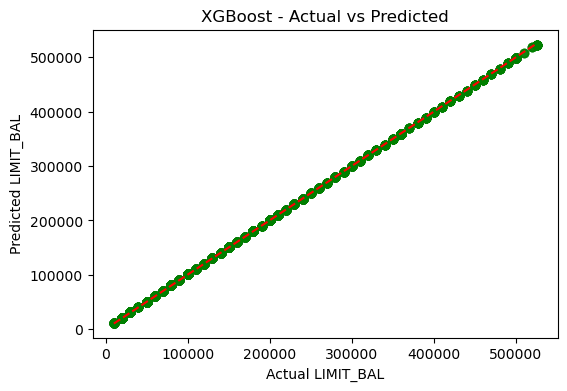

In [16]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('XGBoost - Actual vs Predicted')
plt.xlabel('Actual LIMIT_BAL')
plt.ylabel('Predicted LIMIT_BAL')
plt.show()

In [17]:
from sklearn.svm import SVR
# Khởi tạo mô hình Support Vector Regression (SVR)
svr_model = SVR(
    kernel='rbf',  
    C=100,         
    epsilon=0.1   
)

# Huấn luyện mô hình
svr_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_svr = svr_model.predict(X_test_scaled)
# Đánh giá mô hình
rmse = mean_squared_error(y_test, y_pred_svr, squared=False)
mae = mean_absolute_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)

# Tính phần trăm RMSE và MAE so với giá trị trung bình của LIMIT_BAL
rmse_percent = (rmse / mean_limit_bal) * 100
mae_percent = (mae / mean_limit_bal) * 100

# Hiển thị kết quả dưới dạng phần trăm cho RMSE và MAE, giữ nguyên R²
print(f"RMSE: {rmse:.2f} ({rmse_percent:.2f}%)")
print(f"MAE: {mae:.2f} ({mae_percent:.2f}%)")
print(f"R²: {r2:.6f}")

RMSE: 83864.69 (49.92%)
MAE: 54720.36 (32.57%)
R²: 0.570809
